In [1]:
%matplotlib inline
import numpy as np
import random

import os, sys
import pandas as pd
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from astropy.io import fits
from importlib import reload 

In [2]:
# sys path prepend and reload are for development
sys.path = ['../'] + sys.path
print(sys.path)

['../', '', '/Users/ucapnje/anaconda3/lib/python36.zip', '/Users/ucapnje/anaconda3/lib/python3.6', '/Users/ucapnje/anaconda3/lib/python3.6/lib-dynload', '/Users/ucapnje/.local/lib/python3.6/site-packages', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/aeosa', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/pydelfi-0.1-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/deepmass-0.1-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/skymapper-0.3.2-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/Users/ucapnje/.ipython']


In [3]:
# sys path prepend and reload are for development

from deepmass import map_functions as mf
from deepmass import lens_data as ld
from deepmass import wiener


reload(mf)
reload(ld)
reload(wiener)

<module 'deepmass.wiener' from '../deepmass/wiener.py'>

In [4]:
# def make_healpix_map(ra, dec, weights, nside):
#     pixels= hp.ang2pix(nside,theta = 0.5*np.pi - np.deg2rad(dec), phi = np.deg2rad(ra))
#     bincount = np.bincount(pixels, minlength = hp.nside2npix(nside))
#     bincount_weighted = np.bincount(pixels, minlength = hp.nside2npix(nside), weights=weights)
#     return np.where(bincount>0.5, bincount_weighted/bincount, hp.UNSEEN)

# def shape_noise_realisation(ra, dec, e1_orig, e2_orig, nside):
#     gamma1_shuffle = np.copy(e1_orig)
#     gamma2_shuffle = np.copy(e2_orig)
#     random.shuffle(gamma1_shuffle)
#     random.shuffle(gamma2_shuffle)
#     e1_noise = make_healpix_map(ra, dec, gamma1_shuffle, nside)
#     e2_noise = make_healpix_map(ra, dec, gamma2_shuffle, nside)
#     return e1_noise, e2_noise

# def radial_profile(data):
#     center = data.shape[0]/2
#     y, x = np.indices((data.shape))
#     r = np.sqrt((x - center)**2 + (y - center)**2)
#     r = r.astype(np.int)

#     tbin = np.bincount(r.ravel(), data.ravel())
#     nr = np.bincount(r.ravel())
#     radialprofile = tbin / nr
#     return radialprofile / data.shape[0]**2
    
    
# def compute_spectrum_map(Px,size):
#     power_map = np.zeros((size, size), dtype = float)
#     k_map =  np.zeros((size, size), dtype = float)

#     for (i,j), val in np.ndenumerate(power_map):

#         k1 = i - size/2.0
#         k2 = j - size/2.0
#         k_map[i, j] = (np.sqrt(k1*k1 + k2*k2))

#         if k_map[i,j]==0:
#             #print(i,j)
#             power_map[i, j] = 1e-15
#         else:
#             #print(k_map[i, j])
#             power_map[i, j] = Px[int(k_map[i, j])]
#     return power_map

In [5]:
input_file = '../mice_mock/4432.fits'
hdu_cat =  fits.open(input_file)
print(hdu_cat.info())
mice_cat = hdu_cat[1].data
print(mice_cat.columns)

Filename: ../mice_mock/4432.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     35   499609997R x 7C   [D, D, E, E, E, D, E]   
None
ColDefs(
    name = 'ra_gal'; format = 'D'
    name = 'dec_gal'; format = 'D'
    name = 'kappa'; format = 'E'
    name = 'gamma1'; format = 'E'
    name = 'gamma2'; format = 'E'
    name = 'z_cgal'; format = 'D'
    name = 'cgal'; format = 'E'
)


In [ ]:
z_full = np.array(mice_cat.field('z_cgal'))[:150000000]

In [ ]:
np.max(mice_cat.field('z_cgal'))

In [ ]:
pz_array = np.load(os.getcwd() + '/../mice_mock/stacked_pz.npy')

In [ ]:
ngal_des = 5.9e7
# ngal_des = 3.3e6

In [ ]:
_ = plt.hist(z_full, bins = np.linspace(0,2.5,251), histtype = 'step')
plt.plot(np.linspace(0.0,2.5,250), ngal_des * pz_array)

In [ ]:
np.min(z_full)

In [ ]:
bin_counts_full = np.digitize(z_full, np.linspace(0.0,2.5,251))
hist_full_sim = np.histogram(z_full, bins = np.linspace(0.0,2.5,251))
full_ratio_per_bin = ngal_des * np.divide(pz_array , hist_full_sim[0])

acceptance_sampling_array_full = np.zeros(shape=len(bin_counts_full))
# the maximum value may fall off the last bin with this method, this is a check that there is only one
maximum_value_count = 0
for i in range(len(z_full)):
    if i%1000000==0:
        print(i, len(z_full))
    if bin_counts_full[i] - 1 != 250:
        if 100000.0*full_ratio_per_bin[bin_counts_full[i] - 1] > 10.0*np.random.randint(0,10000):
            acceptance_sampling_array_full[i] = 1.0
    else:
        maximum_value_count += 1
        if 100000.0*full_ratio_per_bin[bin_counts_full[i] - 2] > 10.0*np.random.randint(0,10000):
            acceptance_sampling_array_full[i] = 1.0
            
acceptance_sampling_full_pz = np.where(acceptance_sampling_array_full > 0.5)
mice_pz_cut = z_full[acceptance_sampling_full_pz]

In [ ]:
# np.save('acceptance_190219', acceptance_sampling_full_pz )
acceptance_sampling_full_pz = np.load('acceptance_190219.npy')
mice_pz_cut = z_full[acceptance_sampling_full_pz]

In [ ]:
_ = plt.hist(mice_pz_cut, bins = np.linspace(0.0,2.5,50),  histtype = 'step')
plt.plot(np.linspace(0.0,2.5,250), 5.*ngal_des * pz_array)

# Map

In [6]:
nside = 1024

In [ ]:
ra = np.array(mice_cat.field('ra_gal'))[acceptance_sampling_full_pz]
ra = np.where(ra<0, ra+360., ra)

In [ ]:
dec = np.array(mice_cat.field('dec_gal'))[acceptance_sampling_full_pz]

In [ ]:
kappa = np.array(mice_cat.field('kappa'))[acceptance_sampling_full_pz]

In [ ]:
gamma1 = np.array(mice_cat.field('gamma1'))[acceptance_sampling_full_pz]
gamma2 = np.array(mice_cat.field('gamma2'))[acceptance_sampling_full_pz]

In [ ]:
kappa_map = make_healpix_map(ra, dec, kappa, nside)
gamma1_map = make_healpix_map(ra, dec, gamma1, nside)
gamma2_map = make_healpix_map(ra, dec, gamma2, nside)

In [ ]:
_ = hp.mollview(kappa_map, min=-0.05,max=0.05)

In [7]:
# hp.write_map('kappa_map.fits', kappa_map)
# hp.write_map('gamma1_true_map.fits', gamma1_map)
# hp.write_map('gamma2_true_map.fits', gamma2_map)
nside = 1024
kappa_map = hp.read_map('kappa_map.fits')
gamma1_map = hp.read_map('gamma1_true_map.fits')
gamma2_map = hp.read_map('gamma2_true_map.fits')

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


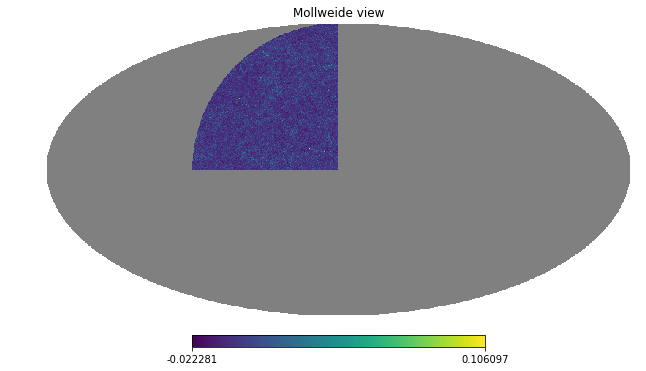

In [8]:
hp.mollview(kappa_map)

# Compare map with NICAEA power

In [9]:
ell_cosmosis = np.loadtxt('../../software/cosmosis-docker/cosmosis/mice_sv_output/shear_cl/ell.txt')
cl_cosmosis = np.loadtxt('../../software/cosmosis-docker/cosmosis/mice_sv_output/shear_cl/bin_1_1.txt')

In [10]:
cell = 8.0*hp.anafast(kappa_map, lmax = 3*1024 - 1)

In [11]:
ell = np.arange(len(cell))

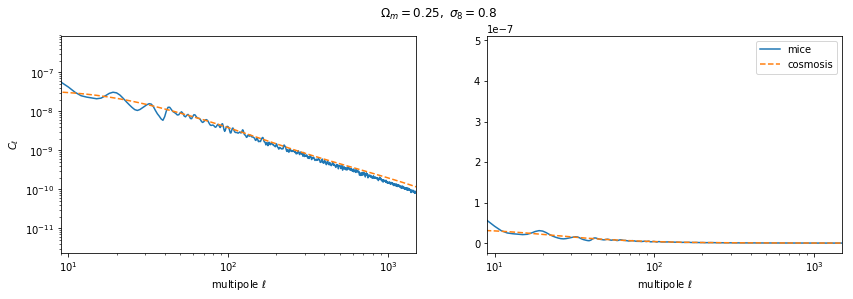

In [12]:
_ = plt.figure(figsize = (14,4))
_ = plt.suptitle(r'$\Omega_m = 0.25,\ \sigma_8 = 0.8$')
_ = plt.subplot(1,2,1)
_ = plt.loglog(ell, cell)
_ = plt.xlim(9,1500)
# _ = plt.ylim(1e-11,5e-8)
_ = plt.loglog(ell_cosmosis, cl_cosmosis, '--')
_ = plt.xlabel(r'multipole $\ell$')
_ = plt.ylabel(r'$C_{{\ell}}$')

_ = plt.subplot(1,2,2)
_ = plt.plot(ell, cell, label = 'mice')
_ = plt.xlim(9,1500), plt.xscale('log')
# _ = plt.ylim(1e-11,5e-8)
_ = plt.plot(ell_cosmosis, cl_cosmosis, '--', label = 'cosmosis')
_ = plt.xlabel(r'multipole $\ell$'), plt.legend()



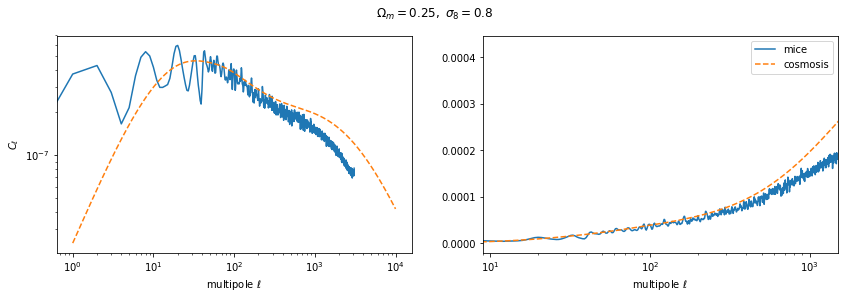

In [13]:
_ = plt.figure(figsize = (14,4))
_ = plt.suptitle(r'$\Omega_m = 0.25,\ \sigma_8 = 0.8$')
_ = plt.subplot(1,2,1)
_ = plt.loglog(ell, cell*ell)
# _ = plt.xlim(9,2000)
# _ = plt.ylim(1e-11,5e-8)
_ = plt.loglog(ell_cosmosis, cl_cosmosis*ell_cosmosis, '--')
_ = plt.xlabel(r'multipole $\ell$')
_ = plt.ylabel(r'$C_{{\ell}}$')

_ = plt.subplot(1,2,2)
_ = plt.plot(ell, cell*(ell+1.)*ell, label = 'mice')
_ = plt.xlim(9,1500), plt.xscale('log')
# _ = plt.ylim(1e-11,5e-8)
_ = plt.plot(ell_cosmosis, cl_cosmosis*ell_cosmosis*(ell_cosmosis+1), '--', label = 'cosmosis')
_ = plt.xlabel(r'multipole $\ell$'), plt.legend()



# DES data for noise

In [14]:
input_file_des = '../mice_mock/cat_DES_SV_zmean_final.fits'
hdu_des =  fits.open(input_file_des)
print(hdu_des.info())
des_cat = hdu_des[1].data
print(des_cat.columns)

Filename: ../mice_mock/cat_DES_SV_zmean_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     26   1628663R x 9C   [D, D, D, D, D, D, D, D, D]   
None
ColDefs(
    name = 'ra_gal'; format = 'D'
    name = 'dec_gal'; format = 'D'
    name = 'zmean'; format = 'D'
    name = 'e1_gal'; format = 'D'
    name = 'e2_gal'; format = 'D'
    name = 'e1_gal_sens'; format = 'D'
    name = 'e2_gal_sens'; format = 'D'
    name = 'coad_id'; format = 'D'
    name = 'sens_avg'; format = 'D'
)


In [15]:
np.mean((des_cat.field('e1_gal_sens') + 1j*des_cat.field('e2_gal_sens')) * np.conj(des_cat.field('e1_gal_sens') + 1j*des_cat.field('e2_gal_sens')))

(0.1642049900284598+0j)

/Users/ucapnje/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


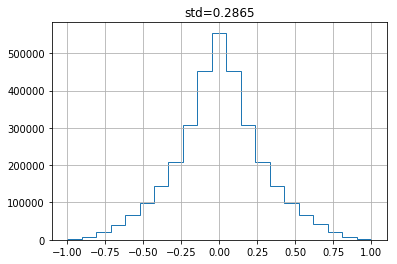

In [16]:
des_galaxy_shapes = np.concatenate([des_cat.field('e1_gal_sens'),des_cat.field('e2_gal_sens')])
std_e1 = np.std(des_galaxy_shapes)
_ = plt.hist(np.concatenate([des_cat.field('e1_gal_sens'),des_cat.field('e2_gal_sens')]),
             histtype='step', bins=np.linspace(-1,1,22))
title = str('std=' + str(std_e1)[:6])
_ = plt.title(title), plt.grid('True')

In [17]:
pixels= hp.ang2pix(nside,theta = 0.5*np.pi - np.deg2rad(des_cat.field('dec_gal')), phi = np.deg2rad(des_cat.field('ra_gal')))
count_map = np.bincount(pixels, minlength = hp.nside2npix(nside))

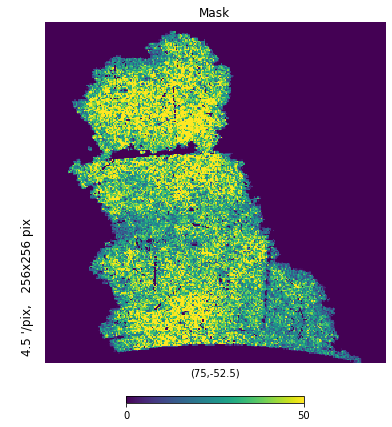

In [18]:
count_gnomview= hp.gnomview(count_map, rot=[+75.0,-52.5],  title='Mask', 
                min = 0, max=50, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
np.save('../mice_mock/sv_counts', np.array(count_gnomview))

In [19]:
sv_mask = np.where(count_map<1,0.,1.)
projected_mask = np.where(count_gnomview<1,0,1)
# np.save('../mice_mock/sv_mask1024', sv_mask)

In [21]:
e1_des_noise, e2_des_noise = ld.shape_noise_realisation(des_cat.field('ra_gal'),
                                                     des_cat.field('dec_gal'),
                                                     des_cat.field('e1_gal_sens'),
                                                     des_cat.field('e2_gal_sens'),
                                                     nside)


../deepmass/lens_data.py:38: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(bincount > 0.5, bincount_weighted / bincount, hp.UNSEEN)
../deepmass/lens_data.py:38: RuntimeWarning: invalid value encountered in true_divide
  return np.where(bincount > 0.5, bincount_weighted / bincount, hp.UNSEEN)


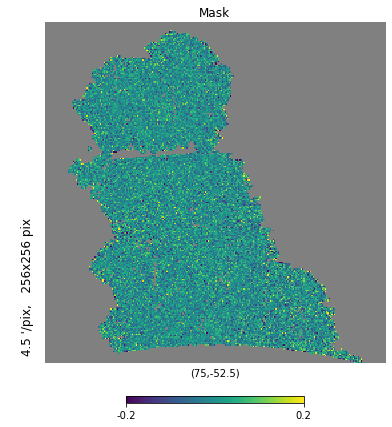

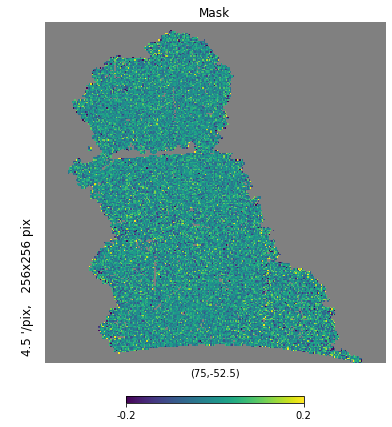

In [22]:
e1_noise_map = hp.gnomview(e1_des_noise, rot=[+75.0,-52.5],  title='Mask', 
                min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)

e2_noise_map = hp.gnomview(e2_des_noise, rot=[+75.0,-52.5],  title='Mask', 
                min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)



# Project

In [23]:
e1_projected_example = hp.gnomview(gamma1_map, rot=[+45.0,30.0],  title='example', 
                                      min = -0.03, max=0.03, reso=4.5, xsize=256, ysize=256,
                                      flip ='geo', return_projected_map =True), plt.close()

e2_projected_example = hp.gnomview(gamma2_map, rot=[+45.0,30.0],  title='example', 
                                      min = -0.03, max=0.03, reso=4.5, xsize=256, ysize=256,
                                      flip ='geo', return_projected_map =True), plt.close()



kappa_projected_example = hp.gnomview(kappa_map, rot=[+20.0,25.0],  title='example', 
                                      min = -0.03, max=0.03, reso=4.5, xsize=256, ysize=256,
                                      flip ='geo', return_projected_map =True), plt.close()



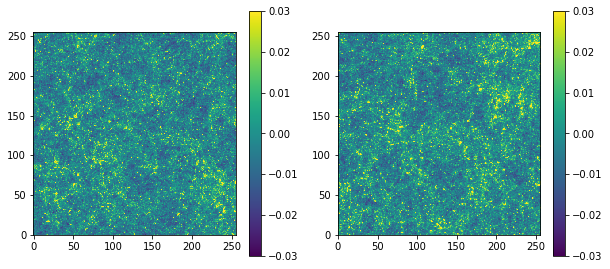

In [24]:
kappa_projected_example_rot = hp.gnomview(kappa_map, rot=[+45.0,30.0, 45.0],  title='example', 
                                      min = -0.03, max=0.03, reso=4.5, xsize=256, ysize=256,
                                      flip ='geo', return_projected_map =True), plt.close()


_ = plt.figure(figsize = (10,4.5))
_ = plt.subplot(1,2,1), plt.imshow(kappa_projected_example[0], origin='lower', clim=(-0.03,0.03)), plt.colorbar()
_ = plt.subplot(1,2,2), plt.imshow(kappa_projected_example_rot[0], origin='lower', clim=(-0.03,0.03)), plt.colorbar()

In [25]:
def compute_spectrum_map(Px,size):
    power_map = np.zeros((size, size), dtype = float)
    k_map =  np.zeros((size, size), dtype = float)

    for (i,j), val in np.ndenumerate(power_map):

        k1 = i - size/2.0
        k2 = j - size/2.0
        k_map[i, j] = (np.sqrt(k1*k1 + k2*k2))

        if k_map[i,j]==0:
            #print(i,j)
            power_map[i, j] = 1e-15
        else:
            #print(k_map[i, j])
            power_map[i, j] = Px[int(k_map[i, j])]
    return power_map


# function to generate a convergence field out of a gaussian spectrum
def generate_gaussian_field(size, intput_power_map =None):
    
    k_map =  np.zeros((size, size), dtype = float)

    
    power_map = np.zeros((size, size), dtype = float)
    for (i,j), val in np.ndenumerate(power_map):

        k1 = i - size/2.0
        k2 = j - size/2.0
        k_map[i, j] = (np.sqrt(k1*k1 + k2*k2))

        if k_map[i,j]==0:
            power_map[i, j] = 1e-15
        else:
            if power_map is None:
                power_map[i, j] = power_function(k_map[i, j], 10.0)
            else:
                power_map[i, j] = intput_power_map[i,j]
            
            
    power_sample = np.random.normal(loc=0.0, scale=np.sqrt(0.5 * np.reshape(power_map, -1))) +\
               1j *  np.random.normal(loc=0.0, scale=np.sqrt(0.5 *  np.reshape(power_map, -1)))
    power_sample = np.reshape(power_sample, (size, size))
    map_fourier = np.zeros((size,size), dtype = complex)
    
    for (i, j,), value in np.ndenumerate(map_fourier):
        n = i - int(size/2)
        m = j - int(size/2)

        if n == 0 and m ==0:
            map_fourier[i,j] = 1e-15

        elif i ==0 or j == 0:
            map_fourier[i,j] = np.sqrt(2.0)*power_sample[i,j].real

        else:
            map_fourier[i,j] = power_sample[i,j] #
            map_fourier[size - i,size - j] = np.conj(power_sample[i,j])

    map_pixel = np.fft.ifft2(np.fft.fftshift(map_fourier))
    
    return map_pixel, power_map

In [26]:
np.var(kappa_projected_example[0])

7.114682496004086e-05

In [29]:
fft2D = np.fft.fft2(kappa_projected_example[0].real)
psd1D_kmt_new = mf.radial_profile(np.fft.fftshift(np.real(fft2D*np.conj(fft2D))))

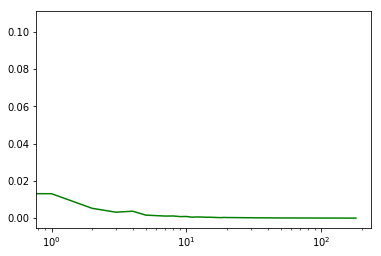

In [30]:
# plt.loglog(psd1D_kmt, color='orange')
plt.plot(psd1D_kmt_new, color='green')
plt.xscale('log')
# plt.loglog(power_avg, color='blue')
# plt.loglog(power_smoothed, 'r--')


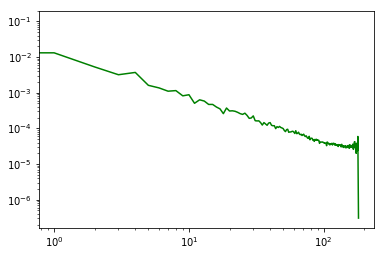

In [31]:
# plt.loglog(psd1D_kmt, color='orange')
plt.loglog(psd1D_kmt_new, color='green')
# plt.loglog(power_avg, color='blue')
# plt.loglog(power_smoothed, 'r--')


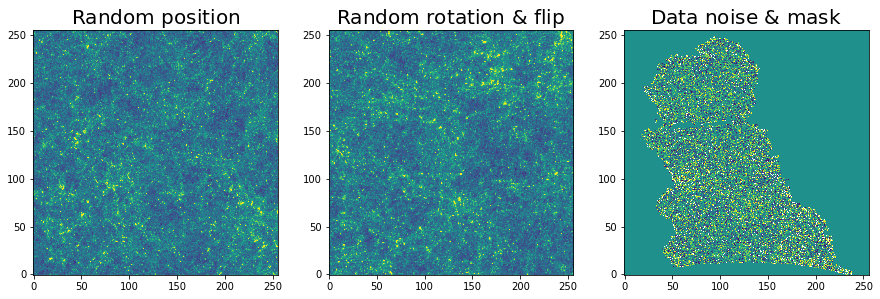

In [32]:
kappa_projected_example_rot = hp.gnomview(kappa_map, rot=[+45.0,30.0, 45.0],  title='example', 
                                      min = -0.03, max=0.03, reso=4.5, xsize=256, ysize=256,
                                      flip ='geo', return_projected_map =True), plt.close()


_ = plt.figure(figsize = (15,4.5))
_ = plt.subplot(1,3,1), plt.imshow(kappa_projected_example[0], origin='lower', clim=(-0.03,0.04))
_ = plt.title(r'$\rm{Random\ position}$', fontsize= 20)
_ = plt.subplot(1,3,2), plt.imshow(kappa_projected_example_rot[0].T, origin='lower', clim=(-0.03,0.04))
_ = plt.title(r'$\rm{Random\ rotation\ &\ flip}$', fontsize= 20)
_ = plt.subplot(1,3,3), plt.imshow(np.where(count_gnomview>0.5, kappa_projected_example_rot[0].T + e1_noise_map, 0),
                                   origin='lower', clim=(-0.1,0.1))
_ = plt.title(r'$\rm{Data\ noise\ &\ mask}$', fontsize= 20)
_ = plt.savefig('rotation.pdf')


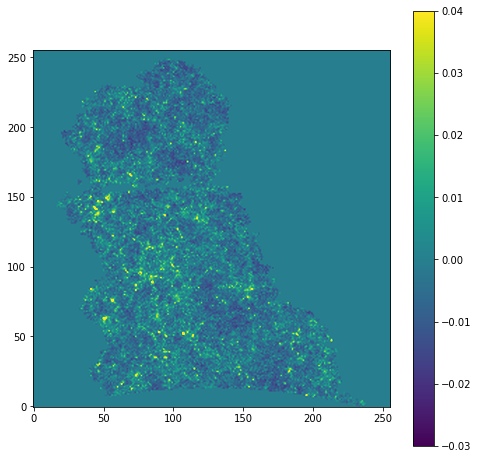

In [33]:
masked_kappa_example = np.where(count_gnomview>0.5, kappa_projected_example[0], 0)
_ = plt.figure(figsize = (8,8))
_ = plt.imshow(masked_kappa_example, interpolation='spline36', origin='lower', clim=(-0.03,0.04)), plt.colorbar()

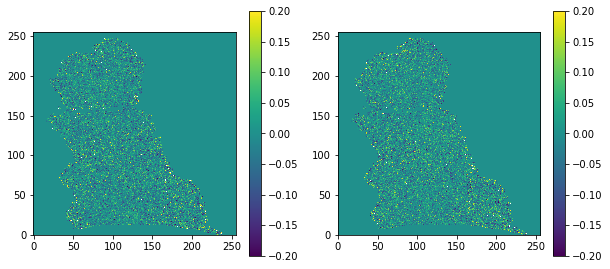

In [34]:
_ = plt.figure(figsize = (10,4.5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(np.where(count_gnomview>0.5, e1_projected_example[0] + e1_noise_map , 0), interpolation='none', origin='lower',
               clim=(-0.2,0.2)), plt.colorbar()

_ = plt.subplot(1,2,2)
_ = plt.imshow(np.where(count_gnomview>0.5, e2_projected_example[0] + e2_noise_map , 0), interpolation='none', origin='lower',
               clim=(-0.2,0.2)), plt.colorbar()


# Make a set of mice mocks (non overlapping)

In [35]:
kappa_copy = np.copy(kappa_map)

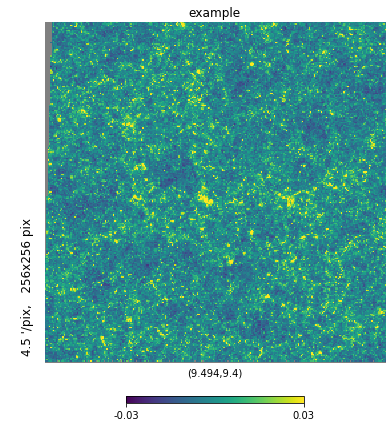

In [36]:
a = hp.gnomview(kappa_map, rot=[9.4*1.01,9.4, 0.0],
                title='example', 
                min = -0.03, max=0.03, reso=4.5, xsize=256, ysize=256,
                flip ='geo', return_projected_map =True)

In [37]:
vec_test = hp.ang2vec(9.4*0.5,9.4*0.5, lonlat=True)

In [38]:
hp.ang2vec(9.4*0.5,9.4*0.5, lonlat=True)

array([0.99328608, 0.08166298, 0.08193851])

In [39]:
tot_count = 0.
theta_patch = []
phi_patch = []
patch_radius = 9.5
kappa_map_labelled = np.copy(kappa_map)
for i in range(5):
    theta_patch.append(18*(0.5+i))
    phi_patch.append(9.4*1.01)
    vec_test = hp.ang2vec(theta_patch[-1],phi_patch[-1], lonlat=True)
    queried_pixels = hp.query_disc(1024, vec_test, np.deg2rad(patch_radius))
    kappa_map_labelled[queried_pixels] += 0.05
    tot_count+=1
    
for i in range(5):
    theta_patch.append(17.8*(0.55+i))
    phi_patch.append(9.4*2.8)
    vec_test = hp.ang2vec(theta_patch[-1],phi_patch[-1], lonlat=True)
    queried_pixels = hp.query_disc(1024, vec_test, np.deg2rad(patch_radius))
    kappa_map_labelled[queried_pixels] += 0.05
    tot_count+=1
    tot_count+=1
    
for i in range(4):
    theta_patch.append(21.5*(0.6+i))
    phi_patch.append(9.4*4.6)
    vec_test = hp.ang2vec(theta_patch[-1],phi_patch[-1], lonlat=True)
    queried_pixels = hp.query_disc(1024, vec_test, np.deg2rad(patch_radius))
    kappa_map_labelled[queried_pixels] += 0.05
    tot_count+=1
    
for i in range(3):
    theta_patch.append(26.5*(0.7+i))
    phi_patch.append(9.4*6.4)
    vec_test = hp.ang2vec(theta_patch[-1],phi_patch[-1], lonlat=True)
    queried_pixels = hp.query_disc(1024, vec_test, np.deg2rad(patch_radius))
    kappa_map_labelled[queried_pixels] += 0.05
    tot_count+=1
    
for i in range(1):
    theta_patch.append(45.*1.1)
    phi_patch.append(19.2*4.)
    vec_test = hp.ang2vec(theta_patch[-1],phi_patch[-1], lonlat=True)
    queried_pixels = hp.query_disc(1024, vec_test, np.deg2rad(patch_radius))
    kappa_map_labelled[queried_pixels] += 0.05
    tot_count+=1
    
print(tot_count)

23.0


30.102628152685384 149.89737184731462 -59.897371847314616 59.897371847314616
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 7 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


(None, None)

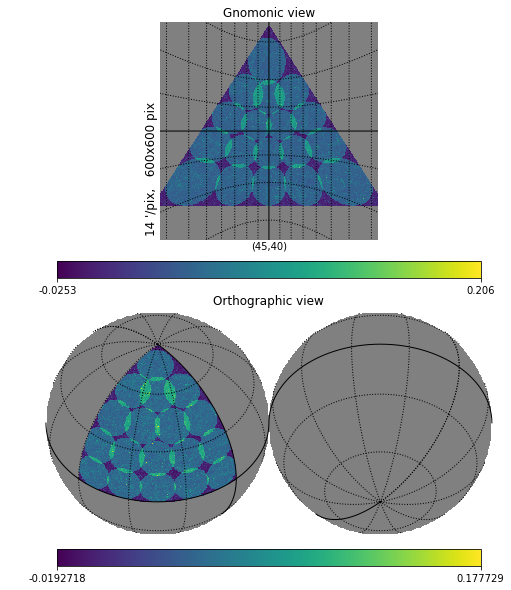

In [40]:
plt.figure(figsize = (12,8))
hp.gnomview(kappa_map_labelled, rot=[45,40.], reso = 14., xsize = 600, sub=(2,1,1))
hp.orthview(kappa_map_labelled, rot=[45,45, 0],  xsize = 600, sub=(2,1,2)), hp.graticule()

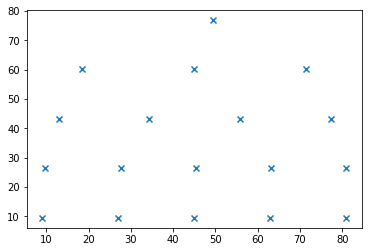

In [41]:
plt.scatter(theta_patch, phi_patch, marker = 'x')

In [ ]:
print(len(theta_patch))
unmasked_pixels = np.where(projected_mask>0)

for i in range(len(theta_patch)):
    print(theta_patch[i],phi_patch[i])

    e1_projected_temp = hp.gnomview(gamma1_map, rot=[theta_patch[i],phi_patch[i]],  title='example', 
                                          min = -0.03, max=0.03, reso=4.5, xsize=256, ysize=256,
                                          flip ='geo', return_projected_map =True), plt.close()

    e2_projected_temp = hp.gnomview(gamma2_map, rot=[theta_patch[i],phi_patch[i]],  title='example', 
                                          min = -0.03, max=0.03, reso=4.5, xsize=256, ysize=256,
                                          flip ='geo', return_projected_map =True), plt.close()



    kappa_projected_temp = hp.gnomview(kappa_map, rot=[theta_patch[i],phi_patch[i]],  title='example', 
                                          min = -0.03, max=0.03, reso=4.5, xsize=256, ysize=256,
                                          flip ='geo', return_projected_map =True), plt.close()
    
    plt.imshow(kappa_projected_temp[0]*(.2+projected_mask), clim=(-0.03,0.03), origin = 'lower'), plt.show()

    if np.ma.is_masked(kappa_projected_temp[0]) == True:
        if len(np.where(kappa_projected_temp[0].mask[unmasked_pixels]==True)[0]) > 0:
            print(i, ' bad pixels = ' +\
                  str(len(np.where(kappa_projected_temp[0].mask[unmasked_pixels]==True)[0])))
            break
            
    
    e1_des_noise, e2_des_noise = shape_noise_realisation(des_cat.field('ra_gal'),
                                                         des_cat.field('dec_gal'),
                                                         des_cat.field('e1_gal_sens'),
                                                         des_cat.field('e2_gal_sens'),
                                                         1024)
    e1_noise_map = hp.gnomview(e1_des_noise, rot=[+75.0,-52.5],  title='Mask', 
        min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
    _ = plt.close()

    e2_noise_map = hp.gnomview(e2_des_noise, rot=[+75.0,-52.5],  title='Mask', 
        min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
    _ = plt.close()


    e1_noisy = np.where(e1_noise_map.mask==False,  e1_noise_map + e1_projected_temp[0], 0.)
    e2_noisy = np.where(e2_noise_map.mask==False,  e2_noise_map + e2_projected_temp[0], 0.)
    
    plt.imshow(e1_noisy, origin = 'lower', clim = (-0.15,0.15)), plt.show()
    
    np.save('../mice_mock/sv_patches/e1_noisy_030419_' + str(i), e1_noisy)
    np.save('../mice_mock/sv_patches/e2_noisy_030419_' + str(i), e2_noisy)
    np.save('../mice_mock/sv_patches/kappa_true_030419_' + str(i), kappa_projected_temp[0].data*projected_mask)
    
    
    plt.imshow(kappa_projected_temp[0].data*projected_mask, origin = 'lower', clim = (-0.025,0.025)), plt.show()
    


86
1.8 11.0


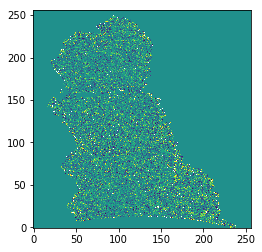

5.4 11.0


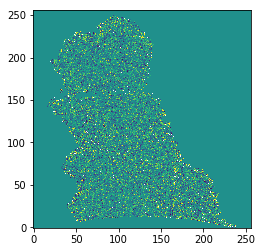

9.0 11.0


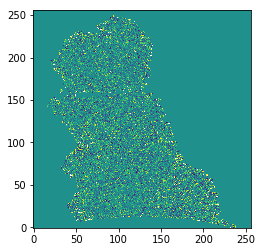

12.600000000000001 11.0


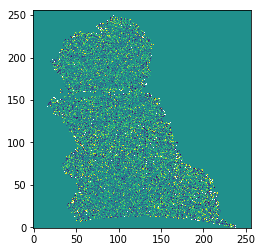

16.2 11.0


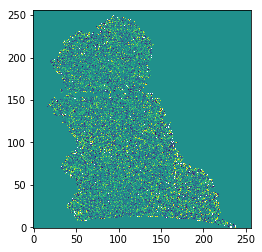

19.8 11.0


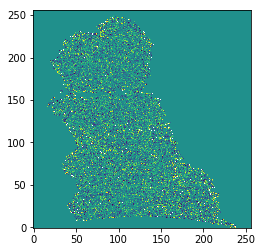

23.400000000000002 11.0


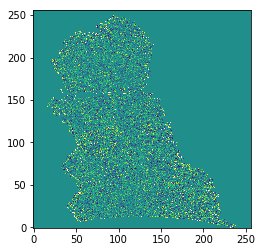

27.0 11.0


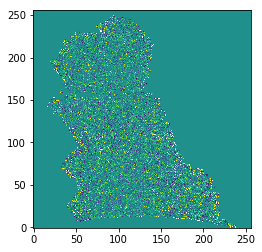

30.6 11.0


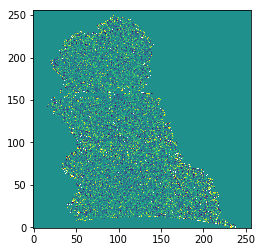

34.2 11.0


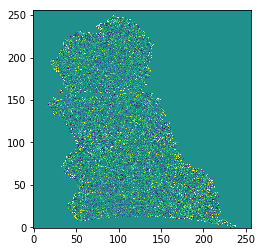

37.800000000000004 11.0


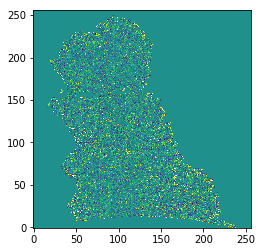

41.400000000000006 11.0


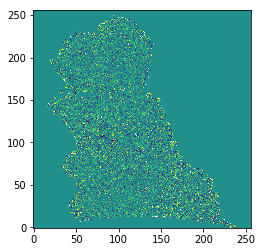

45.0 11.0


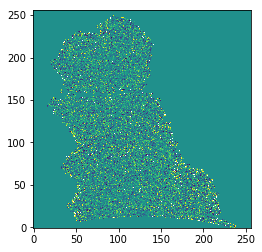

48.6 11.0


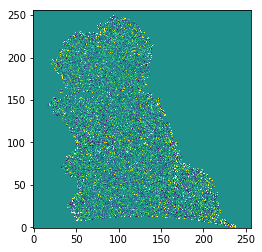

52.2 11.0


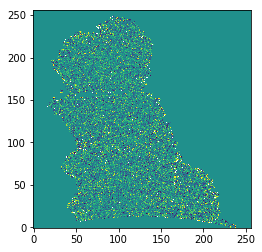

55.800000000000004 11.0


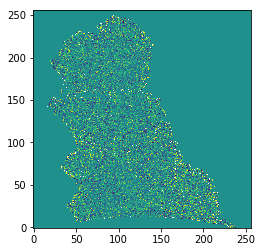

59.400000000000006 11.0


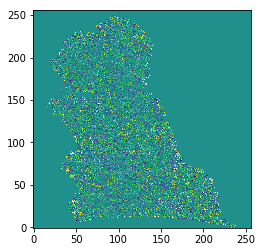

63.0 11.0


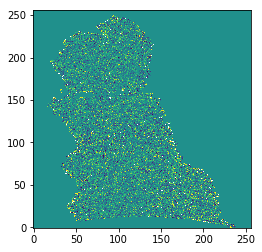

66.60000000000001 11.0


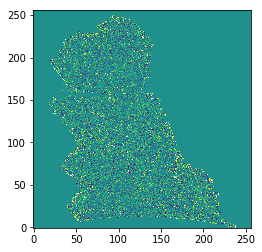

70.2 11.0


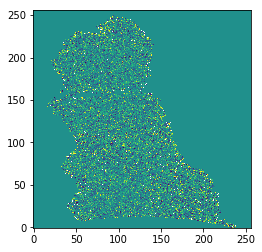

73.8 11.0


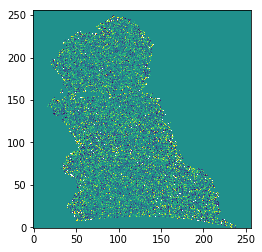

77.4 11.0


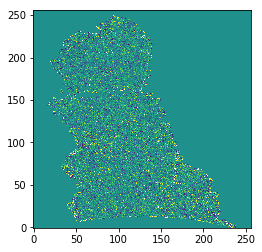

81.0 11.0


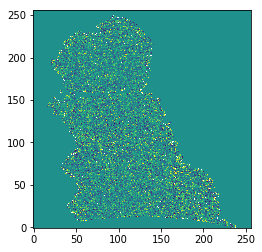

84.60000000000001 11.0


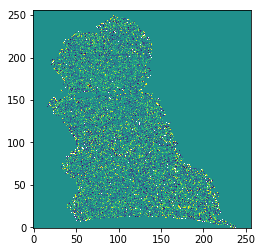

88.2 11.0


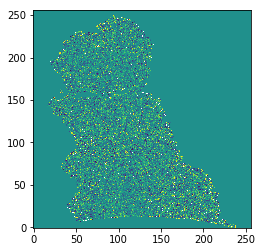

1.9580000000000002 26.32


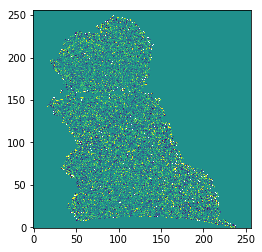

5.518000000000001 26.32


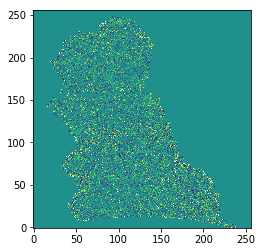

9.078000000000001 26.32


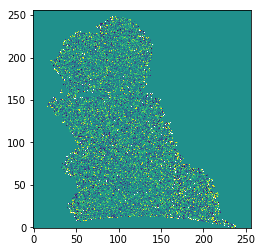

12.638 26.32


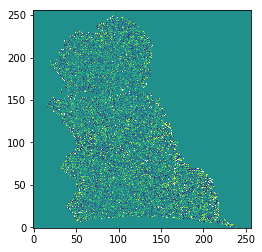

16.198 26.32


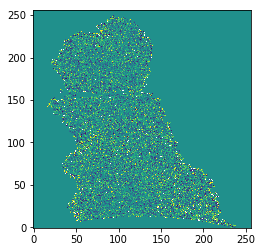

19.758000000000003 26.32


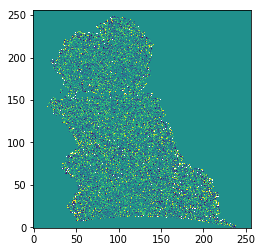

23.318 26.32


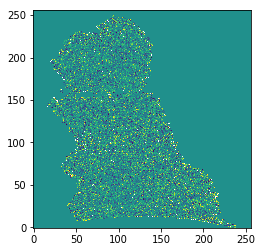

In [59]:
print(len(theta_patch))
unmasked_pixels = np.where(projected_mask>0)

for i in np.arange(32):

    
    e1_des_noise, e2_des_noise = ld.shape_noise_realisation(des_cat.field('ra_gal'),
                                                         des_cat.field('dec_gal'),
                                                         des_cat.field('e1_gal_sens'),
                                                         des_cat.field('e2_gal_sens'),
                                                         1024)
    e1_noise_map = hp.gnomview(e1_des_noise, rot=[+75.0,-52.5],  title='Mask', 
        min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
    _ = plt.close()

    e2_noise_map = hp.gnomview(e2_des_noise, rot=[+75.0,-52.5],  title='Mask', 
        min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
    _ = plt.close()

    e1_noisy = np.where(e1_noise_map.mask==False,  e1_noise_map, 0.)
    e2_noisy = np.where(e2_noise_map.mask==False,  e2_noise_map, 0.)
    
    plt.imshow(e1_noisy, origin = 'lower', clim = (-0.15,0.15)), plt.show()
    
    np.save('../mice_mock/sv_patches/e1_randoms_150719' + str(i), e1_noisy)
    np.save('../mice_mock/sv_patches/e2_randoms_150719' + str(i), e2_noisy)
    


# Calculate the power of projected map

In [42]:
tot_count = 0.
theta_patch = []
phi_patch = []
patch_radius = 9.5
kappa_map_labelled = np.copy(kappa_map)
for i in range(25):
    theta_patch.append(18*(0.5+i)*0.2)
    phi_patch.append(11.)
    vec_test = hp.ang2vec(theta_patch[-1],phi_patch[-1], lonlat=True)
    queried_pixels = hp.query_disc(1024, vec_test, np.deg2rad(patch_radius))
    kappa_map_labelled[queried_pixels] += 0.05
    tot_count+=1
    
for i in range(25): 
    theta_patch.append(17.8*(0.55+i)*0.2)
    phi_patch.append(9.4*2.8)
    vec_test = hp.ang2vec(theta_patch[-1],phi_patch[-1], lonlat=True)
    queried_pixels = hp.query_disc(1024, vec_test, np.deg2rad(patch_radius))
    kappa_map_labelled[queried_pixels] += 0.05
    tot_count+=1
    tot_count+=1
    
for i in range(20):
    theta_patch.append(21.5*(0.6+i)*0.2)
    phi_patch.append(9.4*4.6)
    vec_test = hp.ang2vec(theta_patch[-1],phi_patch[-1], lonlat=True)
    queried_pixels = hp.query_disc(1024, vec_test, np.deg2rad(patch_radius))
    kappa_map_labelled[queried_pixels] += 0.05
    tot_count+=1
    
for i in range(15):
    theta_patch.append(26.5*(0.75+i)*0.2)
    phi_patch.append(9.4*6.4)
    vec_test = hp.ang2vec(theta_patch[-1],phi_patch[-1], lonlat=True)
    queried_pixels = hp.query_disc(1024, vec_test, np.deg2rad(patch_radius))
    kappa_map_labelled[queried_pixels] += 0.05
    tot_count+=1
    
for i in range(1):
    theta_patch.append(45.*1.1)
    phi_patch.append(19.2*4.)
    vec_test = hp.ang2vec(theta_patch[-1],phi_patch[-1], lonlat=True)
    queried_pixels = hp.query_disc(1024, vec_test, np.deg2rad(patch_radius))
    kappa_map_labelled[queried_pixels] += 0.05
    tot_count+=1
    
print(tot_count)

111.0


In [43]:
no_mask_patches = []

for i in range(len(theta_patch)):
    print(theta_patch[i],phi_patch[i])

#     e1_projected_temp = hp.gnomview(gamma1_map, rot=[theta_patch[i],phi_patch[i]],  title='example', 
#                                           min = -0.03, max=0.03, reso=4.5, xsize=256, ysize=256,
#                                           flip ='geo', return_projected_map =True), plt.close()

#     e2_projected_temp = hp.gnomview(gamma2_map, rot=[theta_patch[i],phi_patch[i]],  title='example', 
#                                           min = -0.03, max=0.03, reso=4.5, xsize=256, ysize=256,
#                                           flip ='geo', return_projected_map =True), plt.close()



    kappa_projected_temp = hp.gnomview(kappa_map, rot=[theta_patch[i],phi_patch[i]],  title='example', 
                                          min = -0.03, max=0.03, reso=4.5, xsize=256, ysize=256,
                                          flip ='geo', return_projected_map =True), plt.close()
    
#     plt.imshow(kappa_projected_temp[0]*(.01+projected_mask), clim=(-0.03,0.03), origin = 'lower'), plt.show()
    
    if len(np.where(kappa_projected_temp[0].mask==True)[0]) == 0:
        print('no mask')
        no_mask_patches.append(kappa_projected_temp[0])



1.8 11.0
5.4 11.0
9.0 11.0
12.600000000000001 11.0
no mask
16.2 11.0
no mask
19.8 11.0
no mask
23.400000000000002 11.0
no mask
27.0 11.0
no mask
30.6 11.0
no mask
34.2 11.0
no mask
37.800000000000004 11.0
no mask
41.400000000000006 11.0
no mask
45.0 11.0
no mask
48.6 11.0
no mask
52.2 11.0
no mask
55.800000000000004 11.0
no mask
59.400000000000006 11.0
no mask
63.0 11.0
no mask
66.60000000000001 11.0
no mask
70.2 11.0
no mask
73.8 11.0
no mask
77.4 11.0
no mask
81.0 11.0
84.60000000000001 11.0
88.2 11.0
1.9580000000000002 26.32
5.518000000000001 26.32
9.078000000000001 26.32
12.638 26.32
no mask
16.198 26.32
no mask
19.758000000000003 26.32
no mask
23.318 26.32
no mask
26.878000000000004 26.32
no mask
30.438000000000006 26.32
no mask
33.998000000000005 26.32
no mask
37.55800000000001 26.32
no mask
41.11800000000001 26.32
no mask
44.678000000000004 26.32
no mask
48.23800000000001 26.32
no mask
51.798 26.32
no mask
55.358000000000004 26.32
no mask
58.918000000000006 26.32
no mask
62.4780

In [46]:
power_avg = np.zeros(182)
n_maps_avg = len(no_mask_patches)
for i in range(n_maps_avg):
    fft2D = np.fft.fft2(no_mask_patches[0].real)
    psd1D_kmt = mf.radial_profile(np.fft.fftshift(np.real(fft2D*np.conj(fft2D))))
    power_avg += psd1D_kmt/np.float(n_maps_avg)


In [47]:
len(no_mask_patches)

59

([<matplotlib.lines.Line2D at 0x21000af8d0>], None)

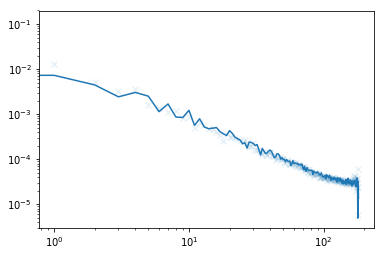

In [48]:
plt.scatter(range(182), psd1D_kmt_new, marker = 'x', alpha = 0.1)
plt.loglog(power_avg), plt.yscale('log')

In [49]:
power_smoothed = np.exp(savgol_filter(np.log(psd1D_kmt_new), 5, 3))

/Users/ucapnje/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [50]:
# power_smoothed[0] = power_avg[0]

([<matplotlib.lines.Line2D at 0x2100317c88>], None)

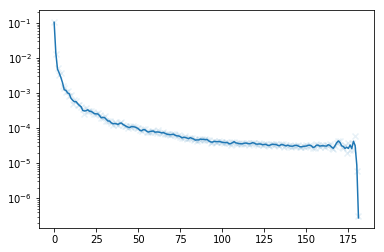

In [51]:
plt.scatter(range(182), psd1D_kmt_new, marker = 'x', alpha = 0.1)
plt.plot(power_smoothed), plt.yscale('log')

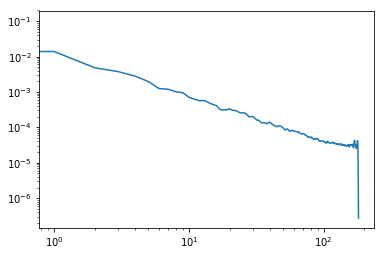

In [52]:
plt.loglog(power_smoothed)

In [54]:
np.save('projected_mice_power_noisy2', power_smoothed)

In [ ]:
Ncov = np.where(count_gnomview>0.0, 2.0 * std_e1 * std_e1 / count_gnomview, 1e18)

In [ ]:
np.save('Ncov', Ncov)

In [ ]:
plt.imshow(np.log10(Ncov), vmin =-2.8, vmax = -1.1, origin = 'lower'), plt.colorbar()

In [ ]:
np.log10(Ncov[np.where(count_gnomview>1.0)]).max()

In [ ]:
std_e1

In [ ]:
(0.25*0.25)/(std_e1*std_e1)